# Importing the required libraries and load the data

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import OrdinalEncoder, LabelEncoder
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from scipy.cluster import hierarchy
import plotly.figure_factory as ff
from sklearn.cluster import AgglomerativeClustering
import seaborn as sns

### Read the dataset

In [2]:
rent_data = pd.read_csv('renttherunway.csv')

### Check first few samples

In [3]:
rent_data.head(5)

,Unnamed: 0,fit,user_id,bust size,item_id,weight,rating,rented for,review_text,body type,review_summary,category,height,size,age,review_date
0,0,fit,420272,34d,2260466,137lbs,10.0,vacation,An adorable romper! Belt and zipper were a lit...,hourglass,So many compliments!,romper,"5' 8""",14,28.0,"April 20, 2016"
1,1,fit,273551,34b,153475,132lbs,10.0,other,I rented this dress for a photo shoot. The the...,straight & narrow,I felt so glamourous!!!,gown,"5' 6""",12,36.0,"June 18, 2013"
2,2,fit,360448,NaN,1063761,NaN,10.0,party,This hugged in all the right places! It was a ...,NaN,It was a great time to celebrate the (almost) ...,sheath,"5' 4""",4,116.0,"December 14, 2015"
3,3,fit,909926,34c,126335,135lbs,8.0,formal affair,I rented this for my company's black tie award...,pear,Dress arrived on time and in perfect condition.,dress,"5' 5""",8,34.0,"February 12, 2014"
4,4,fit,151944,34b,616682,145lbs,10.0,wedding,I have always been petite in my upper body and...,athletic,Was in love with this dress !!!,gown,"5' 9""",12,27.0,"September 26, 2016"


### Shape of the data

In [4]:
rent_data.shape

(192544, 16)

### Display the info of the data

In [5]:
rent_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 192544 entries, 0 to 192543
Data columns (total 16 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   Unnamed: 0      192544 non-null  int64  
 1   fit             192544 non-null  object 
 2   user_id         192544 non-null  int64  
 3   bust size       174133 non-null  object 
 4   item_id         192544 non-null  int64  
 5   weight          162562 non-null  object 
 6   rating          192462 non-null  float64
 7   rented for      192534 non-null  object 
 8   review_text     192476 non-null  object 
 9   body type       177907 non-null  object 
 10  review_summary  192197 non-null  object 
 11  category        192544 non-null  object 
 12  height          191867 non-null  object 
 13  size            192544 non-null  int64  
 14  age             191584 non-null  float64
 15  review_date     192544 non-null  object 
dtypes: float64(2), int64(4), object(10)
memory usage: 23.5+ 

# Data Cleansing and Exploratory Data Aanalysis

### No duplicates found in the data

In [6]:
duplicate_data = rent_data[rent_data.duplicated(keep=False)]
duplicate_data.shape

(0, 16)

### Shape of Actual data is same as data after removing duplicates, so there are no duplicates

In [7]:
unique_data = rent_data.drop_duplicates()
rent_data.shape == unique_data.shape

True

### Dropping the redundant / irrelevant columns for analysis

In [8]:
rent_data = rent_data.drop(columns=['user_id', 'item_id', 'review_text', 'review_summary', 'review_date', 'Unnamed: 0'], axis=1)

### 'weight' column has 'lbs' string attached which is removed and converted to float

In [9]:
rent_data['weight'] = rent_data['weight'].str.replace('lbs', '').astype('float')
rent_data.dtypes

fit            object
bust size      object
weight        float64
rating        float64
rented for     object
body type      object
category       object
height         object
size            int64
age           float64
dtype: object

### Check unique categies and group 'party: cocktail' with 'party' in 'rented for' column

In [10]:
print(rent_data['rented for'].unique())
rent_data[rent_data['rented for'].isin(['party', 'party: cocktail'])]

['vacation' 'other' 'party' 'formal affair' 'wedding' 'date' 'everyday'
 'work' nan 'party: cocktail']


,fit,bust size,weight,rating,rented for,body type,category,height,size,age
2,fit,NaN,NaN,10.0,party,NaN,sheath,"5' 4""",4,116.0
10,small,34b,135.0,8.0,party,athletic,dress,"5' 3""",12,33.0
12,fit,36a,120.0,10.0,party,straight & narrow,sheath,"5' 6""",8,26.0
13,large,36d,142.0,8.0,party,apple,dress,"5' 2""",20,29.0
15,fit,34c,140.0,10.0,party,hourglass,leggings,"5' 7""",20,30.0
...,...,...,...,...,...,...,...,...,...,...
192517,fit,36d,NaN,10.0,party,full bust,top,"5' 8""",20,55.0
192521,small,34c,125.0,10.0,party,full bust,dress,"5' 3""",12,31.0
192522,fit,34a,130.0,8.0,party,athletic,shift,"5' 6""",20,35.0
192525,large,36d,168.0,8.0,party,apple,dress,"5' 7""",24,38.0


### Convert Height in Feets to inches (=feets*12 + inches)

In [11]:
rent_data['height_inches'] = (rent_data.height.str.split("'").str[0].astype(float) * 12) + (rent_data.height.str.split("'").str[1].str.replace('"','').astype(float))
rent_data

,fit,bust size,weight,rating,rented for,body type,category,height,size,age,height_inches
0,fit,34d,137.0,10.0,vacation,hourglass,romper,"5' 8""",14,28.0,68.0
1,fit,34b,132.0,10.0,other,straight & narrow,gown,"5' 6""",12,36.0,66.0
2,fit,NaN,NaN,10.0,party,NaN,sheath,"5' 4""",4,116.0,64.0
3,fit,34c,135.0,8.0,formal affair,pear,dress,"5' 5""",8,34.0,65.0
4,fit,34b,145.0,10.0,wedding,athletic,gown,"5' 9""",12,27.0,69.0
...,...,...,...,...,...,...,...,...,...,...,...
192539,fit,34dd,140.0,10.0,work,hourglass,jumpsuit,"5' 9""",8,42.0,69.0
192540,fit,32c,100.0,10.0,work,petite,dress,"5' 1""",4,29.0,61.0
192541,fit,36a,135.0,6.0,everyday,straight & narrow,dress,"5' 8""",8,31.0,68.0
192542,fit,36c,165.0,10.0,wedding,pear,dress,"5' 6""",16,31.0,66.0


In [12]:
rent_data['age'].unique()

array([ 28.,  36., 116.,  34.,  27.,  45.,  65.,  33.,  30.,  26.,  29.,
        32.,  35.,  21.,  20.,  37.,  50.,  43.,  47.,  53.,  31.,  38.,
        48.,  40.,  52.,  24.,  25.,  nan,  44.,  39.,  49.,  22.,  42.,
        69.,  23.,  17.,  41.,  59.,  56.,  46.,  54.,  51.,  58.,  55.,
        57.,  62.,  19.,  60.,  63.,  61.,  66.,  15.,  70.,  16.,   0.,
        64.,  18.,  87.,  77.,  68.,  67.,   3.,  75.,  91.,  85., 117.,
        72.,   2.,  73.,  71.,  92.,   9.,  99.,   1.,  14., 106.,   8.,
       109.,   4.,  76., 100.,   5.,  74., 113., 115.,  81.,  78.,  97.,
        88., 112.])

### Impute Missing values in each column

Check number of missing values in each columns

In [13]:
rent_data.isna().sum()

fit                  0
bust size        18411
weight           29982
rating              82
rented for          10
body type        14637
category             0
height             677
size                 0
age                960
height_inches      677
dtype: int64

For categorical variables, check frequency of occurence of each category in 'bust size' and replace missing values by mode (category with max count)

In [14]:
print(rent_data['bust size'].value_counts())
rent_data['bust size'] = rent_data['bust size'].fillna('34b')

bust size
34b    27285
34c    23139
34d    18029
36c    13516
32d    11196
       ...  
28i        1
46f        1
42h        1
40i        1
44h        1
Name: count, Length: 106, dtype: int64


In [15]:
print(rent_data['rented for'].value_counts())
rent_data['rented for'] = rent_data['rented for'].fillna('wedding')

rented for
wedding            57784
formal affair      40408
party              35626
everyday           16822
other              15388
work               15042
date                7388
vacation            4075
party: cocktail        1
Name: count, dtype: int64


In [16]:
print(rent_data['body type'].value_counts())
rent_data['body type'] = rent_data['body type'].fillna('hourglass')

body type
hourglass            55349
athletic             43667
pear                 22135
petite               22131
full bust            15006
straight & narrow    14742
apple                 4877
Name: count, dtype: int64


For numerical columns, replacing missing values with mean of respective columns

In [17]:
rent_data['rating'] = rent_data['rating'].fillna(rent_data['rating'].mean())
rent_data['weight'] = rent_data['weight'].fillna(rent_data['weight'].mean())
rent_data['age'] = rent_data['age'].fillna(rent_data['age'].mean())
rent_data['height_inches'] = rent_data['height_inches'].fillna(rent_data['height_inches'].mean())

In [18]:
rent_data = rent_data.drop(columns=['height'], axis=1)    # 'height_inches' column is considered so dropping 'height' column
rent_data.isna().sum()

fit              0
bust size        0
weight           0
rating           0
rented for       0
body type        0
category         0
size             0
age              0
height_inches    0
dtype: int64

### Statistical summary for categorical columns/variables

In [19]:
rent_data.describe(include='object')

,fit,bust size,rented for,body type,category
count,192544,192544,192544,192544,192544
unique,3,106,9,7,68
top,fit,34b,wedding,hourglass,dress
freq,142058,45696,57794,69986,92884


### Statistical summary for numerical columns/variables

In [20]:
rent_data.describe()

,weight,rating,size,age,height_inches
count,192544.000000,192544.000000,192544.000000,192544.000000,192544.000000
mean,137.391709,9.092371,12.245175,33.871017,65.310621
std,20.122771,1.429740,8.494877,8.037969,2.658793
min,50.000000,2.000000,0.000000,0.000000,54.000000
25%,125.000000,8.000000,8.000000,29.000000,63.000000
50%,137.391709,10.000000,12.000000,32.000000,65.000000
75%,145.000000,10.000000,16.000000,37.000000,67.000000
max,300.000000,10.000000,58.000000,117.000000,78.000000


### Plot the distribution of various categories in column 'rented for' using histogram bar plot

In [21]:
pd.DataFrame(rent_data['rented for'].value_counts()) 

,count
rented for,
wedding,57794
formal affair,40408
party,35626
everyday,16822
other,15388
work,15042
date,7388
vacation,4075
party: cocktail,1


C:\Users\Vikrant\AppData\Local\Temp\ipykernel_17956\3449891966.py:7: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=30)


[Text(0, 0, 'wedding'),
 Text(1, 0, 'formal affair'),
 Text(2, 0, 'party'),
 Text(3, 0, 'everyday'),
 Text(4, 0, 'other'),
 Text(5, 0, 'work'),
 Text(6, 0, 'date'),
 Text(7, 0, 'vacation'),
 Text(8, 0, 'party: cocktail')]

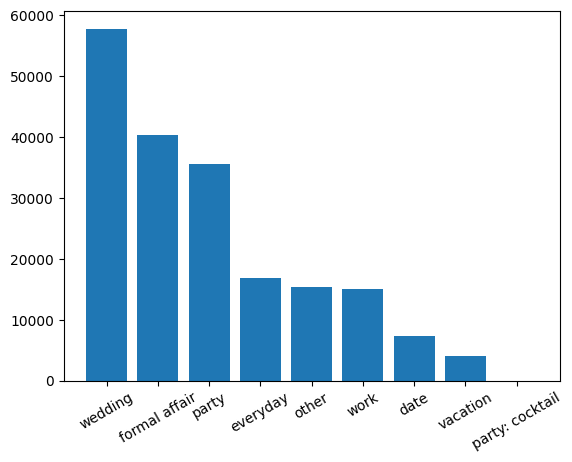

In [22]:
fig, ax = plt.subplots()

x = rent_data['rented for'].value_counts().index.to_list()
y = rent_data['rented for'].value_counts().values

ax.bar(x,y)
ax.set_xticklabels(ax.get_xticklabels(), rotation=30)

### Encode categorical data

In [23]:
rent_data.dtypes

fit               object
bust size         object
weight           float64
rating           float64
rented for        object
body type         object
category          object
size               int64
age              float64
height_inches    float64
dtype: object

In [24]:
enc =  LabelEncoder()
rent_data['fit'] = enc.fit_transform(rent_data['fit'].astype(str))
rent_data['bust size'] = enc.fit_transform(rent_data['bust size'].astype(str))
rent_data['rented for'] = enc.fit_transform(rent_data['rented for'].astype(str))
rent_data['body type'] = enc.fit_transform(rent_data['body type'].astype(str))
rent_data['category'] = enc.fit_transform(rent_data['category'].astype(str))


### Standardize the data (converting all columns in range 0 to 1)

In [25]:
# for col in rent_data.columns:
#     dr = rent_data[col].max() - rent_data[col].min()
#     rent_data[col] = ((rent_data[col] - rent_data[col].min()).div(dr)).astype('float32')

scaler = MinMaxScaler()
model=scaler.fit(rent_data)
scaled_data=model.transform(rent_data)


### Principal Components Analysis (PCA)

In [27]:
pca_model = PCA(n_components=10)
pca_model.fit_transform(scaled_data)
pca_model.explained_variance_ratio_.cumsum()
print(f'Percentage of variance explained by 6 principal components is {100*pca_model.explained_variance_ratio_.cumsum()[5]}')

pca_model = PCA(n_components=6) # fitting the pca model with 6 principal components
rent_data_reduced = pca_model.fit_transform(scaled_data)

Percentage of variance explained by 6 principal components is 94.42035063855492


Sampling 10000 rows (data points) from the actual data

In [28]:
rent_data_sampled = pd.DataFrame(rent_data_reduced).sample(n = 10000) 

### K-means clustering

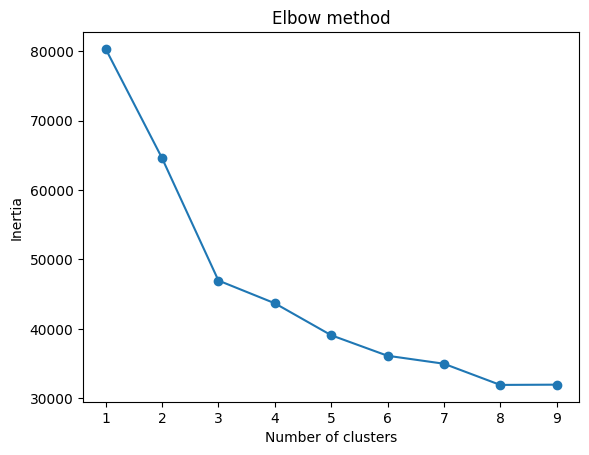

In [29]:
inertias = []

for n in range(9):
    kmeans = KMeans(n_clusters=(n+1))
    kmeans.fit(scaled_data)
    inertias.append(kmeans.inertia_)

plt.plot(range(1,10), inertias, marker='o')
plt.title('Elbow method')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.show()

As seen, optimal number of clusters is 3

In [30]:
kmeans = KMeans(n_clusters=3)
preds = kmeans.fit_predict(rent_data_sampled)

# Calculate the silhouette score
silhoutte_score = silhouette_score(rent_data_sampled, preds)
print(f'Silhouette Score for K-means clustering is {silhoutte_score:.2f}')

Silhouette Score for K-means clustering is 0.28


Spot the longest vertical line and draw the horizontal line and note the number of vertical lines. So, Optimal number of clusters (K=4) 

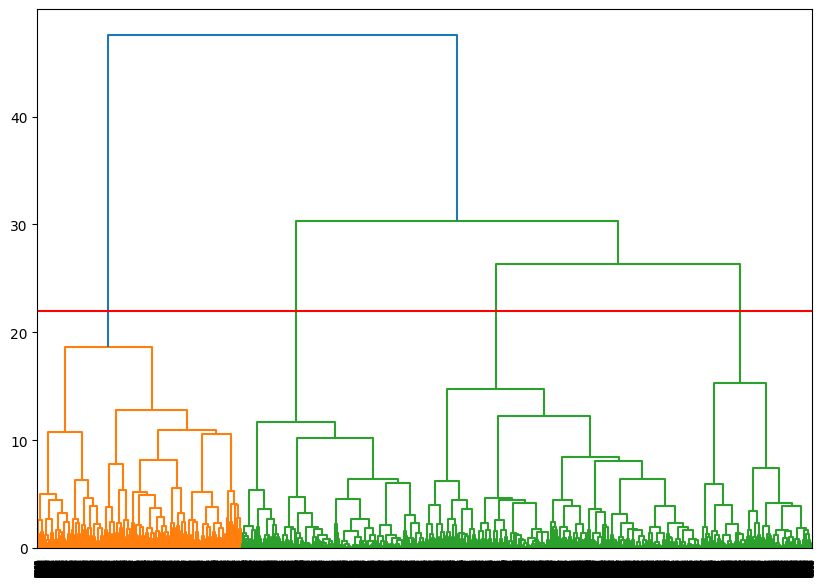

In [31]:
plt.figure(figsize=(10, 7))
Dendrogram = hierarchy.dendrogram((hierarchy.linkage(rent_data_sampled, method ='ward'))) 
plt.axhline(y = 22, color = 'r', linestyle = '-')

In [32]:
clustering_model = AgglomerativeClustering(n_clusters=4, linkage='ward')
clustering_model.fit(rent_data_sampled)


AgglomerativeClustering(n_clusters=4)

In [33]:
labels = clustering_model.fit_predict(rent_data_sampled)

# Calculate the silhouette score
silhouette_score2 = silhouette_score(rent_data_sampled, labels)
print(f'Silhouette Score for Agglomerative clustring is {silhouette_score2:.2f}')

Silhouette Score for Agglomerative clustring is 0.25
